In [5]:
# PARTS-based script to import GMM-derived rain DSDs, set up a model atmosphere with
#  a liquid cloud and a rain layer below it, and simulate GMI-type observations' spread
#  from using fixed RWP with different DSDs 
# [simon wrote much of the below]

# cleaned up in mid dec, d duncan, and committed to github

%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles
%load_ext autoreload
%autoreload 2
from data_provider import DataProvider
import numpy as np
plt.style.use('bmh')

skip_rt_part=True

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles


## PSD Data

In [2]:
ngmm = 6 # number of GMM classes from input data
data = np.load("ND_rwcnorm_"+str(ngmm)+".npy") 
# mean GMM class 1 data (just as example), output from table.ipynb
print(data.shape)
maxb = 80  # can be smaller, but not too few or cutting off big drops
ex = np.load('../OceanRAIN_bincenters.npy')[12:(12+maxb)] #data.shape[1])] # as defined by OR, saved in npy for convenience
#ex = np.load('oceanrain_binsizes.npy')[12:(12+data.shape[1])] # as defined by OR, saved in npy for convenience
x = ex/1e3 # from mm into m
ex = x # save for later use
print(x.shape, ex)

(6, 60)
(80,) [0.000392  0.0004266 0.0004619 0.0004982 0.0005353 0.0005734 0.0006124
 0.0006524 0.0006934 0.0007354 0.0007784 0.0008225 0.0008677 0.000914
 0.0009615 0.0010101 0.00106   0.0011111 0.0011634 0.0012171 0.001272
 0.0013284 0.0013861 0.0014453 0.0015059 0.0015681 0.0016318 0.001697
 0.0017639 0.0018324 0.0019027 0.0019747 0.0020484 0.002124  0.0022015
 0.0022809 0.0023622 0.0024456 0.0025311 0.0026186 0.0027084 0.0028003
 0.0028946 0.0029911 0.0030901 0.0031915 0.0032955 0.003402  0.0035112
 0.003623  0.0037377 0.0038552 0.0039755 0.0040989 0.0042254 0.004355
 0.0044877 0.0046238 0.0047633 0.0049062 0.0050527 0.0052028 0.0053566
 0.0055142 0.0056758 0.0058413 0.006011  0.0061848 0.006363  0.0065456
 0.0067327 0.0069244 0.007121  0.0073223 0.0075287 0.0077402 0.007957
 0.0081791 0.0084067 0.00864  ]


In [3]:
def mgd(in_D,in_Dm,in_mu,in_RWC): #Nw):
    """
     Calcuate the Modified Gamma drop size distribution

     Input (note, all inputs should be vectors of same size!) : 
            in_D:  vector of diameters [mm]
            in_Dm: mass-weighted mean diameter [mm]
            in_mu: shape parameter [dim-less]
            in_RWC: RWC [kg m-3]
            #in_Nw: normalized intercept parameter [IN LOG10()!!] [mm-1 m-3]
     output: N(D) [len(in_D)] in m^{-3} mm^{-1}
    """
    if(len(in_D)==1):
        print("need to input vector for in_D")
    enot = (4**4)/(np.pi*1000.0) * in_RWC/((in_Dm*1e-3)**4) *1e-3 
    # calc intercept param from RWC, Dm -- get units into mm-1 m-3
    #enot = 10**in_Nw
    eff = 6/(4**4) * ((4+in_mu)**(4+in_mu) ) / math.gamma(np.float128(4+in_mu))
    ModGam = enot * eff * (in_D/in_Dm)**in_mu * np.exp(-(4+in_mu)*in_D/in_Dm)
    return ModGam

## Data provider

The data provider provides the data describing the atmospheric state. [set in external file]

[101300  90400  80500  71500  63300  55900  49200  43200  37800  32900
  28600  24700  21300  18200  15600  13200  11100   9370   7890   6660
   5650   4800   4090   3500   3000   2570   1763   1220    852    600
    426    305    220    159    116]
[    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 27500. 30000. 32500. 35000.
 37500. 40000. 42500. 45000. 47500.]
[0.0001 0.0001] [101300  90400] [   0. 1000.]


(0, 18)

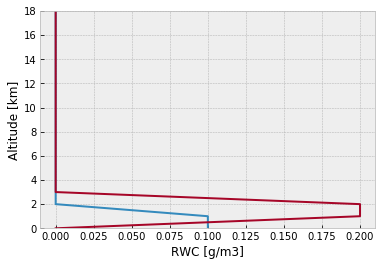

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


rwp = 100e-3     # set RWP [kg/m2]
lwp = 200e-3  # set CLWP [kg/m2]
p0  = 101300 #e5   # lower bound of rain layer (pressure [Pa])
p1 = 9.04e4    # upper ""  --- CANNOT MAKE THINNER WITHOUT ADJUSTING DATAPROVIDER FILE
p2 = 7.8e4

data_provider = DataProvider(rwp, p0, p1, lwp, p1, p2)

# vars just defined here for plotting
p  = data_provider.get_pressure() # if no arg, P is defined as in external DP file
print(p)
z  = data_provider.get_altitude() # """"""
print(z)
md = data_provider.get_rain_mass_density() # in kg/m3
md_cloud = data_provider.get_cloud_mass_density() # in kg/m3
print(md[0:2],p[0:2],z[0:2])


plt.plot(md*1e3, z / 1e3) # alt from m to km
plt.plot(md_cloud*1e3, z / 1e3) # alt from m to km
plt.xlabel("RWC [g/m3]")
plt.ylabel("Altitude [km]")
plt.ylim([0,18])

## Scattering data

We need to interpolate the psd data to match the liquid sphere scattering data.

In [7]:
# load scattering data from Dendrite, then interpolate to match database
ssdb_path = "/home/dudavid/Dendrite/Dendrite/SSDB/ArtsScatDbase/ArtsScatDbase_v1.0.0/StandardHabits/FullSet/"
#ssdb_path = "/home/dudavid/Dendrite/Dendrite/SSDB/SSDB_temp/StandardHabits/"
# 2nd SSDB path has much more spectral resolution ## and takes longer to run
scattering_data = ssdb_path + "LiquidSphere.xml"
scattering_meta = ssdb_path + "LiquidSphere.meta.xml"
from typhon.arts.xml import load
sd = load(scattering_data)
sd_meta = load(scattering_meta)

sd_grid = np.array([m.diameter_volume_equ for m in sd_meta])
sd_grid * 1e3 # so, into m
print('scat data pts in mm: ',sd_grid*1000)

psd_x = sd_grid
psd_shape = np.interp(sd_grid, x[:60], data[0, :])

scat data pts in mm:  [1.2429443e-03 1.0558760e-03 1.6312339e-03 2.1408232e-03 2.9665952e-03
 2.6609240e-03 4.3405893e-03 6.0148691e-03 7.0805163e-03 9.2924343e-03
 1.1549978e-02 1.5158134e-02 1.8840715e-02 2.4726461e-02 3.0733613e-02
 4.0334641e-02 5.0133711e-02 6.5795232e-02 8.1779807e-02 1.0732741e-01
 1.3340199e-01 1.7507611e-01 2.2976901e-01 2.8559008e-01 3.7480700e-01
 4.6586421e-01 6.1139787e-01 7.5993348e-01 9.9733292e-01 1.2396292e+00
 1.6268832e+00 2.0221252e+00 2.6538270e+00 3.2985591e+00 4.3290126e+00
 5.3807214e+00 7.0616320e+00 8.7772150e+00 1.1519173e+01 1.4317690e+01
 1.8790466e+01 2.3355502e+01 3.0651644e+01 3.8098285e+01 5.0000000e+01]


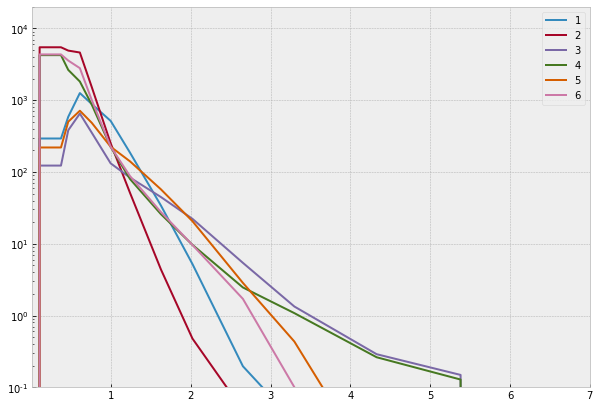

In [6]:
# verify that interpolated DSD matches the input closely [check]
plt.figure(figsize=[10,7])
for p in range(ngmm):
    yessir = np.interp(sd_grid, x[:60], data[p, :])
    yessir[psd_x > .006] = 0.0
    yessir[psd_x < .0001] = 0.0
    #print(yessir)
    plt.plot(psd_x*1000, yessir , label=str(p+1))
    #plt.plot(psd_x*1000, np.interp(sd_grid, x, data[p, :]) , label=str(p+1))
#plt.plot(psd_x*1000, np.interp(sd_grid, x, mgd(x*1000,Dmi,mui,0.0003)))#data_provider.get_rain_mass_density()[0])))
plt.yscale("log")
plt.xlim([.01,7])
plt.ylim([1e-1,2e4])
plt.legend()

## Parts simulation -- import parts

In [7]:
import sys
sys.path += ["/home/dudavid/src/parts"] # to verify that PARTS is in the system path
#sys.path

In [8]:
from parts import ArtsSimulation
from parts.scattering import ScatteringSpecies
from parts.atmosphere import Atmosphere1D
from parts.sensor import PassiveSensor, ICI
from parts.atmosphere.absorption import O2, N2, H2O
from parts.atmosphere.surface import Tessem
from parts.scattering.solvers import RT4, Disort

Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


### Fixed-shape psd

The FixedShape class  represents PSD data that has a fixed shape. It takes the mass density profile provided by the data provider and multiplies it with the normalized PSD shape.

In [9]:
from parts.scattering.psd.fixed_shape import FixedShape
#from parts.scattering.psd.modified_gamma import ModifiedGamma

psd = FixedShape(psd_x, psd_shape)  # initialize 'psd' object

#psd_mgd = ModifiedGamma()
# instead of using ModifiedGamma function... calculate manually and set as new fixed shape
Dmi, mui = 1.5, 2

#mgd_shape = mgd(x*1000, 1.3, 3, data_provider.get_rain_mass_density() ) # D, Dm, mu, RWC
#psd_shape_mgd = np.interp(sd_grid, x, mgd_shape)
mgd_psd = FixedShape(psd_x, np.interp(sd_grid,x,mgd(x*1000, Dmi, mui, data_provider.get_rain_mass_density()[0])))
#plt.plot(x*1000, mgd(x*1000, Dmi, mui, data_provider.get_rain_mass_density()[0]))

### Atmosphere

In [10]:
from parts.scattering.psd import D14  # Delanoe 2014 PSD (for now, since it's in parts)
# add cloud layer properties
cloud = ScatteringSpecies("cloud", D14(1.0, 2.0, rho = 1000.0),
                        scattering_data = scattering_data,
                        scattering_meta_data = scattering_meta)
#psd = D14(1.0, 2.0, rho = 1000.0)

In [11]:
#data_provider.get_cloud_mass_weighted_diameter()

In [12]:
# add rain species, setup atmospheric abs and scat species, plus surface

rain = ScatteringSpecies("rain", psd,
                        scattering_data = scattering_data,
                        scattering_meta_data = scattering_meta)

atmosphere = Atmosphere1D(absorbers = [O2(), N2(), H2O()],
                          scatterers = [rain, cloud],
                          surface = Tessem())  # Tessem sfc model currently only option in PARTS

### Sensor

In [8]:
#channels = np.array([10.65e9, 18.7e9, 23.8e9, 36.65e9, 89e9]) #, 166e9, 180.31e9, 190.31e9]) # made-up sensor for now

channels = np.array([19e9, 36.5e9, 89e9]) # picked 3 GMI frequencies
#channels = np.array([18.7e9, 36.64e9, 89e9]) # picked 3 GMI frequencies
ch_str = ['18GHz','36GHz','89GHz']
nch = channels.size
gmi = PassiveSensor("gmi", channels, stokes_dimension = 1) 
gmi.sensor_line_of_sight = np.array([[135.0]]) # angle from SC, not EIA
gmi.sensor_position = np.array([[407e3]]) # alt in m
gmi.iy_unit = "PlanckBT"  # since using Disort, no V/H polarization information...

NameError: name 'PassiveSensor' is not defined

### Running the simulation

In [14]:
from typhon.arts.workspace.api import arts_api

In [15]:
simulation = ArtsSimulation(atmosphere = atmosphere,
                            data_provider = data_provider,
                            sensors = [gmi])
#simulation.scattering_solver = Disort() 
#RT4(nstreams = 8, auto_inc_nstreams = 8, robust = 1) # use this or else problems?


#simulation.scattering_solver = RT4(nstreams = 4, auto_inc_nstreams = 16, robust = 1) # use this or else problems?
simulation.scattering_solver = Disort(nstreams = 32)
simulation.setup()
simulation.run()
print("TEST SIMULATION: ")
print(gmi.y)

ARTS[94423700768864]: Executing /home/dudavid/arts/controlfiles/general/general.arts
ARTS[94423700768864]: {
ARTS[94423700768864]: - verbosityInit
ARTS[94423700768864]: - scat_speciesSet
ARTS[94423700768864]: - MatrixSet
ARTS[94423700768864]: - Tensor4SetConstant
ARTS[94423700768864]: - ArrayOfStringSet
ARTS[94423700768864]: - Touch
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - ArrayOfStringSet
ARTS[94423700768864]: - MatrixSet
ARTS[94423700768864]: - NumericSet
ARTS[94423700768864]: - ArrayOfStringSet
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - Tensor3SetConstant
ARTS[94423700768864]: - IndexSet
ARTS[94423700768864]: - IndexSet
ARTS[94423700768864]: - IndexSet
ARTS[94423700768864]: - IndexSet
ARTS[94423700768864]: - FlagOff
ARTS[94423700768864]: - output_file_formatSetAsci

ARTS[94423700768864]: - ReadXML

ARTS[94423700768864]: - ReadXML

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Delete

ARTS[94423700768864]: - Delete

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - ReadXML

ARTS[94423700768864]: - ReadXML

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Delete

ARTS[94423700768864]: - Delete

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Append

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - TessemNNReadAscii

ARTS[94423700768864]: - TessemNNReadAscii

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - Copy

ARTS[94423700768864]: - scat_dataCalc

ARTS[94423700768864]: - C

ARTS[94423700768864]: - DisortCalcWithARTSSurface

ARTS[94423700768864]: - yCalc

TEST SIMULATION: 
[[205.71061901]
 [233.75742295]
 [283.56273261]]


In [16]:
#FixedShape.shape?
ws = simulation.workspace
ws.verbositySet(agenda = 0, screen = 0, file = 0)

ARTS[94423700768864]: - verbositySet



In [17]:
# run a case with RWP=0 to form base case
data_provider.rwp = 0
simulation.run()
base_tb = np.array(np.copy(gmi.y).ravel())
print('BASE TB with RWP=0: ',base_tb)
np.save('savetb/base',base_tb) # be careful this is from the same setup

BASE TB with RWP=0:  [203.81930357 230.36897711 281.10786743]


In [18]:
# try running through RWP values and assess spread in Tb intensity
# THIS WILL TAKE HOURS IF USING MANY DATA POINTS!!!!!
rwp_max = 0.6
rwp_step = .08
rwp_vals = np.arange(0.001,rwp_max,rwp_step) # since 0 will be same for all

sv_tb = np.zeros([nch, rwp_vals.size, ngmm+1])
#print(sv_tb.shape)
#
#if not skip_rt_part:
#    for r in range(len(rwp_vals)):
#        print('RWP loop: ',rwp_vals[r])
#        for s in range(ngmm):
#            data_provider.rwp = rwp_vals[r]
#            new_shape = np.interp(sd_grid, x, data[s,:])
#            new_shape[sd_grid > .006] = 0.0 # limiting weird stuff from huge drops
#            new_shape[sd_grid < .0001] = 0.0
#            simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
#            simulation.run()
#            sv_tb[:,r,s] = np.ravel(np.copy(gmi.y)) #-base_tb
#            #print(s,np.trapz(psd.shape.ravel() * psd_x ** 3, x = psd_x), data_provider.rwp) # verify mass-weighted drops
#
#        # then with a token MGD curve -- defined above
#        new_shape = np.interp(sd_grid, x, mgd(x*1000,Dmi,mui,1.0)) # fixedshape will normalize, so rwc doesn't matter
#        new_shape[sd_grid > .006] = 0.0 # limiting weird stuff from huge drops
#        new_shape[sd_grid < .0001] = 0.0
#        simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
#        simulation.run()
#        sv_tb[:,r,s+1] = np.ravel(np.copy(gmi.y)) #-base_tb
#        psd = simulation.atmosphere.scatterers[0].psd
#
#np.save('savetb/save_smo'+smoo)

In [19]:
psd.psd.get_mass_density()
from copy import copy
psd_2 = copy(psd)
psd_2.psd.data = psd.shape
psd_2.psd.get_mass_density()
psd_2.size_parameter.b

3.0

In [20]:
psd = simulation.atmosphere.scatterers[0].psd
#plt.plot(psd_x, psd.shape.ravel())

In [21]:
#plt.style.use('bmh')
#fs=14
#for c in range(len(channels)):
#    fx=plt.figure(figsize=[14,9])
#    plt.plot(rwp_vals, sv_tb[c,:,s+1]-bass[c],'k--',label=ch_str[c]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui)+')')
#    for s in range(ngmm):
#        plt.plot(rwp_vals, sv_tb[c,:,s]-bass[c],'--',label=ch_str[c]+', GMM'+str(s+1))
#    plt.legend(fontsize=fs,loc='upper left')
#    plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
#    plt.ylabel('$\Delta T_B$ [K]',fontsize=fs+4)
#    plt.xticks(fontsize=fs)
#    plt.yticks(fontsize=fs)
#    fx.savefig('../img/gmm_passive_clwp200.'+ch_str[c]+'.v1.png',dpi=300)

In [22]:
#print(info(sv_tb))
#plt.style.use('bmh')
#plt.figure(figsize=[14,9])
#fs=14
#plt.plot(rwp_vals, sv_tb[0,:,s+1]-bass[0],'k--', label=ch_str[0]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui))
#plt.plot(rwp_vals, sv_tb[1,:,s+1]-bass[1],'-.',  label=ch_str[1]+', MGD')
#plt.plot(rwp_vals, sv_tb[2,:,s+1]-bass[2],'k',   label=ch_str[2]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui))
#for s in range(ngmm):
#    plt.plot(rwp_vals, sv_tb[0,:,s]-bass[0],'--',label=ch_str[0]+', GMM'+str(s+1))
#    plt.plot(rwp_vals, sv_tb[1,:,s]-bass[1],'-.',label=ch_str[1]+', GMM'+str(s+1))
#    plt.plot(rwp_vals, sv_tb[2,:,s]-bass[2],     label=ch_str[2]+', GMM'+str(s+1))
#plt.legend(fontsize=fs,loc='upper left')
#plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
#plt.ylabel('$\Delta T_B$ [K]',fontsize=fs+4)
#
#plt.figure(figsize=[14,9])
#for ch in range(len(channels)):
#    plt.plot(rwp_vals, np.std(sv_tb[ch,:,:ngmm], axis=1), label=ch_str[ch])
#fs=14
##plt.title("Stddev(TB) with "+str(ngmm)+" classes",fontsize=fs)
#plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
#plt.ylabel("$\sigma (T_B)$ [K]",fontsize=fs+4)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)
#plt.legend(fontsize=fs,loc='upper left')

In [23]:
#ws = simulation.workspace
#y  = ws.pnd_field
#
#psd = simulation.atmosphere.scatterers[0].psd
#x = psd._wsvs["x"]
#x.ws = simulation.workspace
##plt.plot(x.value[:] * 1000.0, y.value[:, 0, 0, 0])
##plt.yscale("log")
##plt.xlim([.3,4])
#

In [22]:
# Running the simulation setup for 'native' OceanRAIN data... read in output from collate_m first
#  then use the fixed shape parts call to run fwd model without modifying input data.
typ = 'M4' #Ss3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
lo = np.load(dir_raw_data+'alllond'+typ+'.npy')# [::per]
la = np.load(dir_raw_data+'alllatd'+typ+'.npy')# [::per]
epo= np.load(dir_raw_data+'allepochd'+typ+'.npy')# [::per]
rcts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy').transpose()#[::per,:] # raw (per mm) counts

# averaging over consecutive time steps to give a little spatial averaging sense
#   [if location varies very little for consecutive points then put them together]

en = np.size(lo)
rcts_newer = rcts + np.nan
mo = 8 #3   # this is smoothing referred to in the paper:
s_mo = str(2*mo)
if mo > 0: 
    smoof = 'S'+s_mo 
else:
    smoof=''
c=0
cdex = []
for f in range(en-2*mo)[mo:]:
    space_var = np.std(lo[(f-mo):(f+mo+1)])+np.std(la[(f-mo):(f+mo+1)])
    time_var  = np.std(epo[(f-mo):(f+mo+1)])
    if space_var < 0.1 and time_var < 500:  # so ~10km max, mostly within 5min?
        rcts_newer[c,:] = np.mean(rcts[(f-mo):(f+mo+1),:], axis=0)
        cdex.append(f)
        c+=1
print(c,'smoof='+smoof)
print(rcts_newer.shape)
rcts_newer = rcts_newer[:c,:]
print(rcts_newer.shape)
        
# take every _th point to save time:
per = 3 #3

rcts_newer = rcts_newer[::per,:maxb]
dm = np.load(dir_raw_data+'alldmd'+typ+'.npy')[cdex][::per]
rr = np.load(dir_raw_data+'allrrd'+typ+'.npy')[cdex][::per]
ku = np.load(dir_raw_data+'allkud'+typ+'.npy')[cdex][::per]
ka = np.load(dir_raw_data+'allkad'+typ+'.npy')[cdex][::per]
mu = np.load(dir_raw_data+'allmud'+typ+'.npy')[cdex][::per]
nw = np.log10( np.load(dir_raw_data+'allnwd'+typ+'.npy')[cdex][::per] ) # given as log10()
print(np.mean(mu),np.mean(dm),np.mean(nw))
print(rcts_newer.shape)
nor = dm.size

# read in 80 size bins above, trim to __ in rest of code
#maxb = 60  # set now at top
bye = 1 # how many consecutive bins to sum/avg over
cts_new = np.array([ np.mean(rcts_newer[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(maxb/bye)) ]).transpose()


50390 smoof=S16
(92116, 80)
(50390, 80)
4.28593373816753 1.1925945109245697 3.7361934187542714
(16797, 80)


In [44]:
#d_mid = np.array([ np.mean(ex[n:n+2]) for n in range(int(mb/bye)) ]) # diam midpoint in m
#dD = [1e3*(ex[n+1]-ex[n]) for n in range(len(ex)-1)]  #delta D in mm

# calculate RWC from the raw data  i.e. RWC = rho*sum(4/3 pi r^3 dr)
LWC = np.array([1000.0*1000.0*np.pi/6 * np.trapz( cts_new[i,:] * (ex[:])**3, ex) for i in range(nor)]) 
# should be in kg/m^3 (so multiply by maybe 500m to get an idea of rwp)

print(info(LWC))  # old: ['5.36E-6', '5.25E-3', '1.81E-4', '2.90E-4']
np.save('savetb/OR_native'+smoof+'_LWC.every'+str(per),LWC) ## NOTE SMOOTHED OR NOT WITH 'S' (set above)

['1.03E-5', '3.94E-3', '2.10E-4', '3.05E-4']


In [45]:
zees = data_provider.get_altitude()[data_provider.get_rain_mass_density() > 0] #.size
print(zees) # tops of atmospheric levels
deltaz = 1000 #zees[-1] #- 0 # should give change in altitude, RWP depth
# THIS ASSUMES RAIN LAYER IS UNIFORM, ETC. AS ASSUMED ABOVE
print(deltaz)

[   0. 1000.]
1000


In [46]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y[1:], box, mode='same')
    y_smooth = np.append(y[0],y_smooth) # to leave first point unchanged\n",
    return y_smooth

# Assess Tb sensitivity if using GMM classes vs. MGD with set mu

In [47]:
# data output from gmm_solo, saved as npy arrays for labels (1 to nc) and posterior probabilities of 0 to 1

nc = 6 #10 # number of classes (IF NOT CORRECT (with what's been run) THIS WILL GIVE BAD RESULTS)
inty = 'MSs3' # input data type -- extra s for more smoothing (n=5 instead of n=3)
# kind of overrides above input type, but this GMM run is stable and well-characterized

ddir = '/home/dudavid/projects/dsd/dj/OceanClustering/Data_store/'
post_prob = np.load(ddir+'GMM-postprob_rwcnorm_'+str(nc)+'.'+inty+'.npy')[::per]
labels    = np.load(ddir+'GMM-labels_rwcnorm_'+str(nc)+'.'+inty+'.npy')[::per]

# re-read in the mean GMM vectors to ensure consistency:
gmm_means = np.load(ddir+'ND_rwcnorm_'+str(nc)+'.npy')

In [41]:
#tb_gmm = np.zeros([nor,nch]) # save TBs output from simulation
#
#for i in range(nor):
#    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
#    # use GMM-defined shape instead:
#    new_shape = np.interp(sd_grid, x, gmm_means[labels[i],:])
#    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
#    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
#    simulation.run()
#    
#    if np.mod(i,39)==0:  # just for checking as it runs
#        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp,i,nor )
#        
#    tb_gmm[i,:] = np.ravel(np.copy(gmi.y))
#    
#np.save('savetb/OR_gmm'+smoof+'_tbs_1kmlayer.every'+str(per),tb_gmm)

In [42]:
#tb_mgd = np.zeros([nor,nch]) # save TBs output from simulation
#
#for i in range(nor):
#    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
#    # use MGD-defined shape instead:
#    new_shape = np.interp(sd_grid, x, mgd(x*1000, dm[i], 3.0, 1.0)) # fixedshape will normalize, so rwc doesn't matter
#    #new_shape = np.interp(sd_grid, x, gmm_means[labels[i],:])
#    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
#    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
#    simulation.run()
#    
#    if np.mod(i,39)==0:  # just for checking as it runs
#        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp,i,nor )
#        
#    tb_mgd[i,:] = np.ravel(np.copy(gmi.y))
#    
#np.save('savetb/OR_mgd'+smoof+'_tbs_1kmlayer.every'+str(per),tb_mgd)

# Assess 'natural' Tb sensitivity separated by RWC

In [48]:
tb_or = np.zeros([nor,nch]) # save TBs output from simulation

for i in range(nor):
    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
    #if data_provider.rwp < 0.1:
    #    data_provider.rwp = 0.1 # kg/m3 * m
    new_shape = np.interp(sd_grid, x, smooth(cts_new[i,:],5))  # smooth to limit interp issues
    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
    simulation.run()
    
    if np.mod(i,50)==0:  # just for checking as it runs
        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp, i,nor )
    tb_or[i,:] = np.ravel(np.copy(gmi.y))
    
np.save('savetb/OR_native'+smoof+'_tbs_1kmlayer.every'+str(per),tb_or) ## NOTE SMOOTHED OR NOT WITH 'S' (set above)

TB: [205.49761415 234.58649754 282.65502035] 0.0385631315785937 0 16797
TB: [206.37129769 237.53164496 282.83048286] 0.05589782638788802 50 16797
TB: [218.20574455 253.56637861 283.80605778] 0.1667906719280595 100 16797
TB: [206.72597671 236.01485128 281.98109834] 0.03209581632493018 150 16797
TB: [217.87130249 252.14302641 284.29926613] 0.18659299634778403 200 16797
TB: [217.91595674 249.15303751 283.89695973] 0.1487141746333465 250 16797
TB: [207.71071988 238.1918091  282.69749163] 0.05507179122189921 300 16797
TB: [208.49869022 238.81011128 282.56957764] 0.05462305578900418 350 16797
TB: [211.11584378 246.26571265 283.11801629] 0.10182891657141785 400 16797
TB: [208.80040961 238.6894923  282.35277812] 0.04827731710518589 450 16797
TB: [212.876643   248.49616568 283.20208667] 0.11447884425040332 500 16797
TB: [205.82739502 234.34321997 282.21540346] 0.032006890913691625 550 16797
TB: [205.57916481 235.22022896 282.92345771] 0.04746113966736326 600 16797
TB: [205.82380495 234.9666686 

TB: [220.17252766 253.82088006 283.50399789] 0.15971311344424366 5450 16797
TB: [210.43298196 241.64895914 282.61263675] 0.06490628193243565 5500 16797
TB: [233.79116628 270.31629282 284.5078851 ] 0.3743534642505834 5550 16797
TB: [210.60661789 238.26187712 282.08464542] 0.05274852302176704 5600 16797
TB: [211.96141326 244.71554153 283.02115591] 0.09096703084348731 5650 16797
TB: [219.21960554 251.70794892 283.31411717] 0.13779439063209564 5700 16797
TB: [208.62403754 243.13158071 282.77665052] 0.08171759876427133 5750 16797
TB: [206.56785388 235.97723771 282.77106518] 0.0451473352022123 5800 16797
TB: [207.55921246 238.04753185 282.3162246 ] 0.04469339877999123 5850 16797
TB: [218.14436961 252.89811312 283.58012954] 0.15038983807919606 5900 16797
TB: [230.76760557 263.1955353  284.30939184] 0.2871254315587845 5950 16797
TB: [204.53203921 232.33546912 281.89505317] 0.01690071433875169 6000 16797
TB: [222.50493613 252.80286319 283.34204271] 0.15314568682319757 6050 16797
TB: [227.931576

TB: [204.59142803 232.61750102 281.72086703] 0.016099065687396913 10850 16797
TB: [207.04054519 236.40873612 282.17590144] 0.039501071182107904 10900 16797
TB: [207.36421685 236.78468657 282.1162754 ] 0.03830099429273863 10950 16797
TB: [206.9190315  238.98361938 283.63691994] 0.08278241965443303 11000 16797
TB: [273.92327486 281.84895968 286.06406574] 1.1857838253570148 11050 16797
TB: [207.04993648 236.36091176 282.23579825] 0.04015634964967434 11100 16797
TB: [211.24100309 241.19613298 282.37220945] 0.059582834794428566 11150 16797
TB: [206.20187994 236.96024358 282.21661678] 0.040528871919240844 11200 16797
TB: [205.53215369 235.58413362 282.93593736] 0.04877618632174835 11250 16797
TB: [215.12181683 250.61647176 283.17757977] 0.12714331979341945 11300 16797
TB: [271.31893867 281.3337994  285.74704209] 0.9569076951793447 11350 16797
TB: [213.79931652 249.21535308 283.21814806] 0.11926970667935664 11400 16797
TB: [235.05429239 271.56030159 284.3230479 ] 0.36614372912647286 11450 167

TB: [212.77962632 248.96536347 284.53129432] 0.16097083623363298 16200 16797
TB: [214.12874616 248.90479414 284.07095198] 0.14102815543027936 16250 16797
TB: [256.44713043 276.68155954 285.41669846] 0.6641836027837997 16300 16797
TB: [209.0940515  245.00273021 284.22993603] 0.1307536696532112 16350 16797
TB: [207.2053385 239.1021194 283.2561684] 0.06971637562476972 16400 16797
TB: [206.12971702 236.99380244 282.60296191] 0.04742432020494764 16450 16797
TB: [219.05481805 259.0622586  284.6534272 ] 0.25350566601380964 16500 16797
TB: [214.11812672 253.27659745 284.43113874] 0.19192327323115288 16550 16797
TB: [214.9555194  253.79354392 283.88268364] 0.17095826071584527 16600 16797
TB: [243.11791131 274.11542594 284.8123557 ] 0.4740409635683502 16650 16797
TB: [228.90719993 265.79367281 285.1729203 ] 0.3668808349561314 16700 16797
TB: [209.88201908 242.77885379 283.2229341 ] 0.08387321287807203 16750 16797


### Results

In [23]:
per = 3 # 3 is highest number run so far
# pre-supposes that smoothed and unsmoothed array have been run:
tborS= np.load('savetb/OR_native'+smoof+'_tbs_1kmlayer.every'+str(per)+'.npy') # smoothed!
tbor = np.load('savetb/OR_native_tbs_1kmlayer.every'+str(per)+'.npy') # unsmoothed!
lwcS = np.load('savetb/OR_native'+smoof+'_LWC.every'+str(per)+'.npy') 
lwcnS= np.load('savetb/OR_native_LWC.every'+str(per)+'.npy') 
bass = np.load('savetb/base.npy')
print(shinfo(tbor),shinfo(lwcnS))
print(shinfo(tborS),shinfo(lwcS))

deltaz=1000. # also sloppy
nch = 3

rwp_h = np.array([0,.02,.04,.06,.08,.1,.125,.15,.175,.2,.23,.265,.3,.35,.4,.45,.5,.6])
mnsS, mns  = np.zeros([rwp_h.size-1,nch]), np.zeros([rwp_h.size-1,nch])
stdsS,stds = np.zeros([rwp_h.size-1,nch]), np.zeros([rwp_h.size-1,nch])
for ar in range(rwp_h.size-1):
    ndex = np.logical_and(lwcnS*deltaz <= rwp_h[ar+1], lwcnS*deltaz > rwp_h[ar])
    sdex = np.logical_and(lwcS*deltaz <= rwp_h[ar+1], lwcS*deltaz > rwp_h[ar])
    mns[ar,:]  = np.mean( tbor[ndex,:]-bass, axis=0 )
    stds[ar,:] = np.std(  tbor[ndex,:], axis=0 )
    mnsS[ar,:]  = np.mean( tborS[sdex,:]-bass, axis=0 )
    stdsS[ar,:] = np.std(  tborS[sdex,:], axis=0 )


['2.04E+2', '2.89E+2', '2.49E+2', '3.04E+1', (30706, 3)] ['5.96E-6', '8.02E-3', '1.99E-4', '3.52E-4', (30706,)]
['2.04E+2', '2.88E+2', '2.50E+2', '2.96E+1', (16797, 3)] ['1.03E-5', '3.94E-3', '2.10E-4', '3.05E-4', (16797,)]


NameError: name 'stap' is not defined

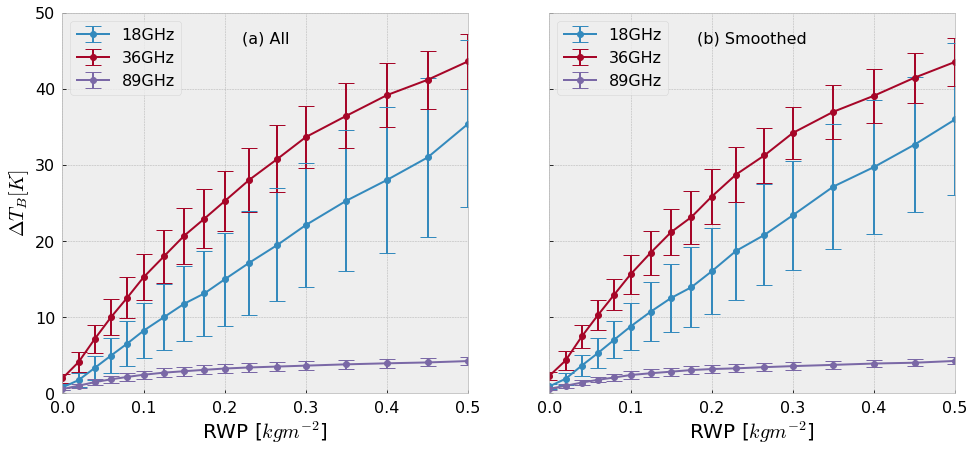

In [24]:
fie, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,7],sharex=True,sharey=True)

fs = 16
for c in range(len(channels)):
    ax[0].errorbar(rwp_h[:-1], mns[:,c], stds[:,c], label=ch_str[c], fmt='-o', capsize=8)
ax[0].legend(fontsize=fs,loc='upper left')
ax[0].set_xlim([0,0.5])
ax[0].set_ylim([0,50])
ax[0].tick_params(labelsize=fs,axis='both',pad=7)
ax[0].set_ylabel('$\Delta T_B [K]$',fontsize=fs+4)
ax[0].set_xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)

for c in range(len(channels)):
    ax[1].errorbar(rwp_h[:-1], mnsS[:,c], stdsS[:,c], label=ch_str[c], fmt='-o', capsize=8)
ax[1].legend(fontsize=fs,loc='upper left')
ax[1].set_xlim([0,0.5])
ax[1].set_ylim([0,50])
ax[1].tick_params(labelsize=fs,axis='both',pad=7)
#ax[1].set_ylabel('$\Delta T_B [K]$',fontsize=fs+4)
ax[1].set_xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)
ax[0].text(.25, 46, '(a) All', fontsize=fs, horizontalalignment='center')
ax[1].text(.25, 46, '(b) Smoothed', fontsize=fs, horizontalalignment='center')


fie.savefig('../img/nat_passive-'+smoof+'_2pan_clwp200_3freq_v4_every'+str(per)+'.png',\
              dpi=300,bbox_inches='tight',transparent=True)
stap

In [1]:
#f_nat = plt.figure(figsize=[12,9])
#fs = 14
#for c in range(len(channels)):
#    ax[0].errorbar(rwp_h[:-1], mns[:,c], stds[:,c], label=ch_str[c], fmt='-o', capsize=8)
#plt.legend(fontsize=fs,loc='upper left')
#plt.xlim([0,0.5])
#plt.ylim([0,50])
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)
#plt.ylabel('$\Delta T_B [K]$',fontsize=fs+4)
#plt.xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)
#
#f_nat.savefig('../img/nat_passive_clwp200_3freq_v2'+smoof+'_every'+str(per)+'.png',\
#              dpi=300,bbox_inches='tight',transparent=True)

# Radar variability

In [ ]:

# now do the same type of analysis, but with radar reflectivities (no need to fwd model!)

In [19]:
rr_h = 2**(np.arange(-3,5.7,.15))
print(rr_h)
mns_dbz  = np.zeros([rr_h.size-1,2])
stds_dbz = np.zeros([rr_h.size-1,2])
for ar in range(rr_h.size-1):
    dex = np.logical_and(rr <= rr_h[ar+1], rr > rr_h[ar])
    #ku_z, ka_z = 10**(ku[dex]*.1), 10**(ka[dex]*.1)
    print(ku[dex].size)
    mns_dbz[ar,:]  = [ np.mean( ku[dex] ),np.mean( ka[dex] )]
    stds_dbz[ar,:] = [ np.std(  ku[dex] ),np.std(  ka[dex] )] 
    

dbz_h = np.arange(12,45,1)
stds_rr =  np.zeros([dbz_h.size-1,2])
mns_rr =  np.zeros([dbz_h.size-1,2])
for ar in range(dbz_h.size-1):
    dexu = np.logical_and(ku <= dbz_h[ar+1], ku > dbz_h[ar])  # based on Ku refl only!
    dexa = np.logical_and(ka <= dbz_h[ar+1], ka > dbz_h[ar])  # based on Ka refl only!
    #print(info(rr[dexu]))
    mns_rr[ar,:] =  [ np.mean( rr[dexu] ),np.mean(  rr[dexa] )] 
    stds_rr[ar,:] = [ np.std( rr[dexu] ),np.std(  rr[dexa] )]


[ 0.125       0.13869618  0.15389305  0.17075503  0.18946457  0.2102241
  0.23325825  0.25881623  0.28717459  0.31864016  0.35355339  0.39229205
  0.43527528  0.48296816  0.53588673  0.59460356  0.65975396  0.73204285
  0.8122524   0.90125046  1.          1.10956947  1.23114441  1.36604026
  1.51571657  1.68179283  1.86606598  2.07052985  2.29739671  2.54912125
  2.82842712  3.13833639  3.48220225  3.86374532  4.28709385  4.75682846
  5.27803164  5.85634278  6.49801917  7.2100037   8.          8.87655578
  9.84915531 10.92832205 12.12573253 13.45434264 14.92852786 16.56423878
 18.37917368 20.39297004 22.627417   25.10669113 27.85761803 30.90996253
 34.2967508  38.05462768 42.22425314 46.85074227]
94
208
223
99
350
229
198
300
312
360
367
332
362
403
431
426
515
440
487
476
523
532
526
499
491
483
489
437
455
470
392
368
352
339
352
338
279
286
250
227
204
183
179
179
138
117
97
116
82
82
64
51
34
45
41
38
17


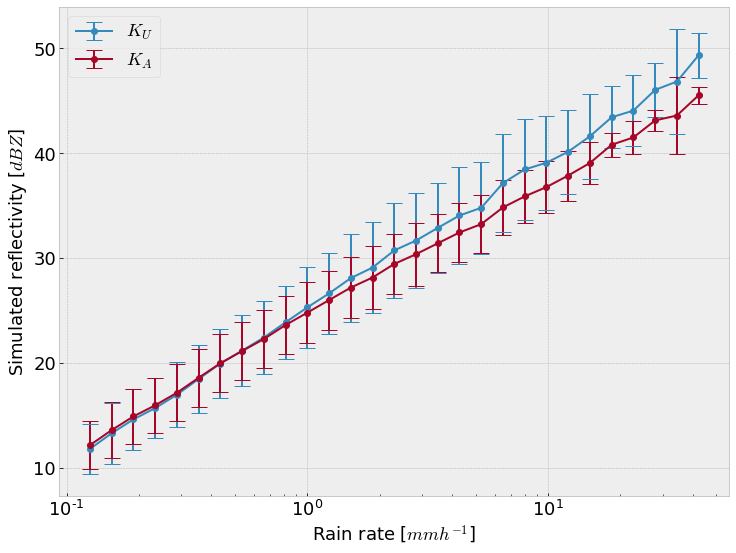

In [20]:
r1 = plt.figure(figsize=[12,9])
fs = 14
bye = 2
plt.errorbar(rr_h[:-1:bye], mns_dbz[::bye,0], stds_dbz[::bye,0], label='$K_U$', fmt='-o', capsize=8)
plt.errorbar(rr_h[:-1:bye], mns_dbz[::bye,1], stds_dbz[::bye,1], label='$K_A$', fmt='-o', capsize=8)
plt.legend(fontsize=fs+4,loc='upper left')
plt.xscale('log')
plt.ylabel('Simulated reflectivity [$dBZ$]',fontsize=fs+4)
plt.xlabel('Rain rate [$mm h^{-1}$]', fontsize=fs+4)
plt.xticks(fontsize=fs+4)
plt.yticks(fontsize=fs+4)

r1.savefig('../img/nat_active_rr-sigdbz_2freq_v5.png',dpi=300,bbox_inches='tight',transparent=True)


In [ ]:
# NOTE: this plot is problematic because of two things:
#  1. OR has a 0.1mm/hr cutoff in recorded rain rate, plus the axis is log, so std deviations look very skewed
#  2. Some obs of very low reflectivities have very high rain rates, which also skews statistics heavily
# In some bins, std > mean and so the plot routine struggles to make bars :| 
sodontplothisrightnow

r2 = plt.figure(figsize=[12,9])
bye=1
plt.errorbar(dbz_h[:-1:bye], mns_rr[::bye,0], stds_rr[::bye,0], label='$K_U$', fmt='-o', capsize=8)
plt.errorbar(dbz_h[:-1:bye], mns_rr[::bye,1], stds_rr[::bye,1], label='$K_A$', fmt='-o', capsize=8)
#plt.plot(dbz_h[:-1], stds_rr[:,0], label='Ku')
#plt.plot(dbz_h[:-1], stds_rr[:,1], label='Ka')
plt.legend(fontsize=fs+4,loc='upper left')
plt.xticks(fontsize=fs+4)
plt.yticks(fontsize=fs+4)
plt.ylabel('Rain rate [$mm h^{-1}$]',fontsize=fs+4)
plt.yscale('log')
#plt.ylabel('$\sigma$(RR) [$mm hr^{-1}$]',fontsize=fs+4)
plt.xlabel('Simulated reflectivity [$dBZ$]',fontsize=fs+4)

r2.savefig('../img/nat_active_dbz-sigrr.2freq.v3.png',dpi=300,bbox_inches='tight',transparent=True)